In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [10]:
#Importing dataset

df = pd.read_csv('../Data/final_ncaa_data.csv')

In [11]:
df.columns

Index(['Player', 'BLK%', 'STL%', 'ORB%', 'DRB%', 'AST%', 'TO%', 'GP', 'FT%',
       'ORtg', '3P%_NCAA', 'PORPAG', 'Adj_O_Eff', 'Mid%', 'O_BPM', 'PTS_PG',
       '3PT/100', 'TS%', 'USG', '3P', 'FTM', 'Recruiting_Rank', 'Class',
       'Year', 'Height (inches)', 'NBA Adjusted 3P%'],
      dtype='object')

In [12]:
#For feature selection. Checking correlation with target and multicollinearity

numerical_columns = df.drop(columns=["Player"])

In [13]:
# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Get correlations for the "Salary" column
target_correlation = correlation_matrix["NBA Adjusted 3P%"]

# Sort correlations in decreasing order
sorted_correlations = target_correlation.sort_values(ascending=False)

# Print sorted correlations
print(sorted_correlations)

NBA Adjusted 3P%    1.000000
3PT/100             0.685864
FT%                 0.560292
3P                  0.537653
3P%_NCAA            0.384465
O_BPM               0.292084
PORPAG              0.164723
ORtg                0.154447
PTS_PG              0.145706
Year                0.143835
Adj_O_Eff           0.126763
AST%                0.123801
GP                  0.101901
Class               0.072985
Mid%                0.058699
STL%                0.028408
FTM                 0.022788
TS%                 0.020717
USG                -0.024253
Recruiting_Rank    -0.120075
TO%                -0.239963
DRB%               -0.351561
Height (inches)    -0.357303
BLK%               -0.465042
ORB%               -0.489108
Name: NBA Adjusted 3P%, dtype: float64


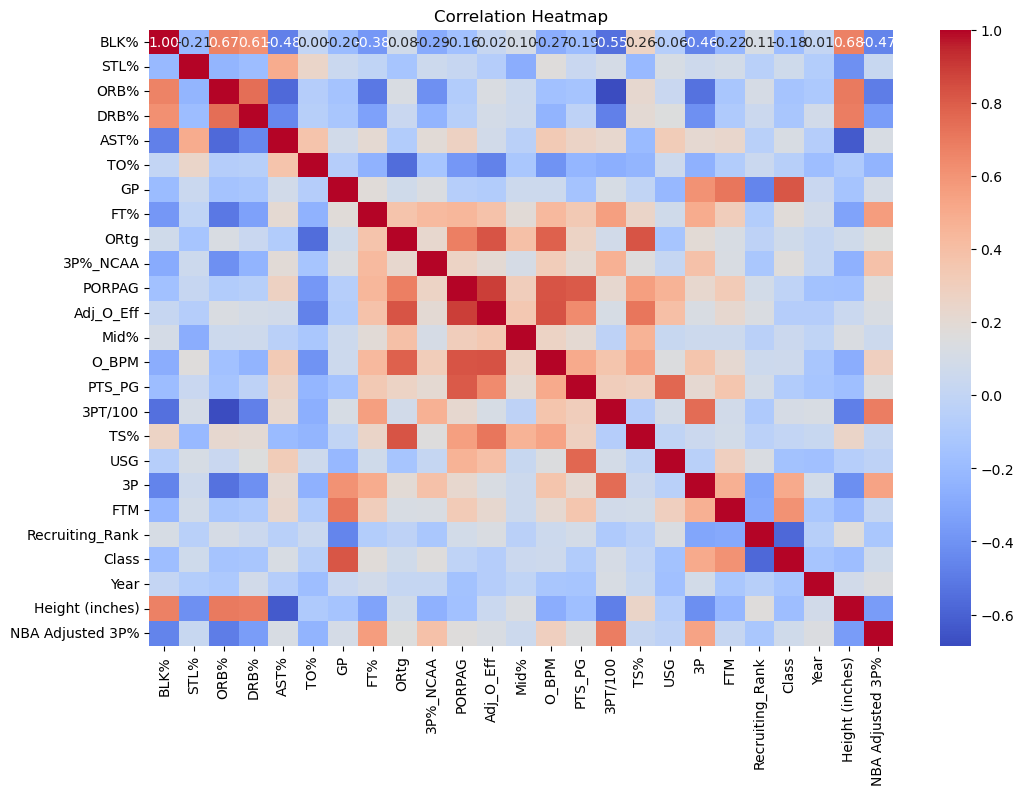

In [14]:
correlation_matrix = numerical_columns.corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

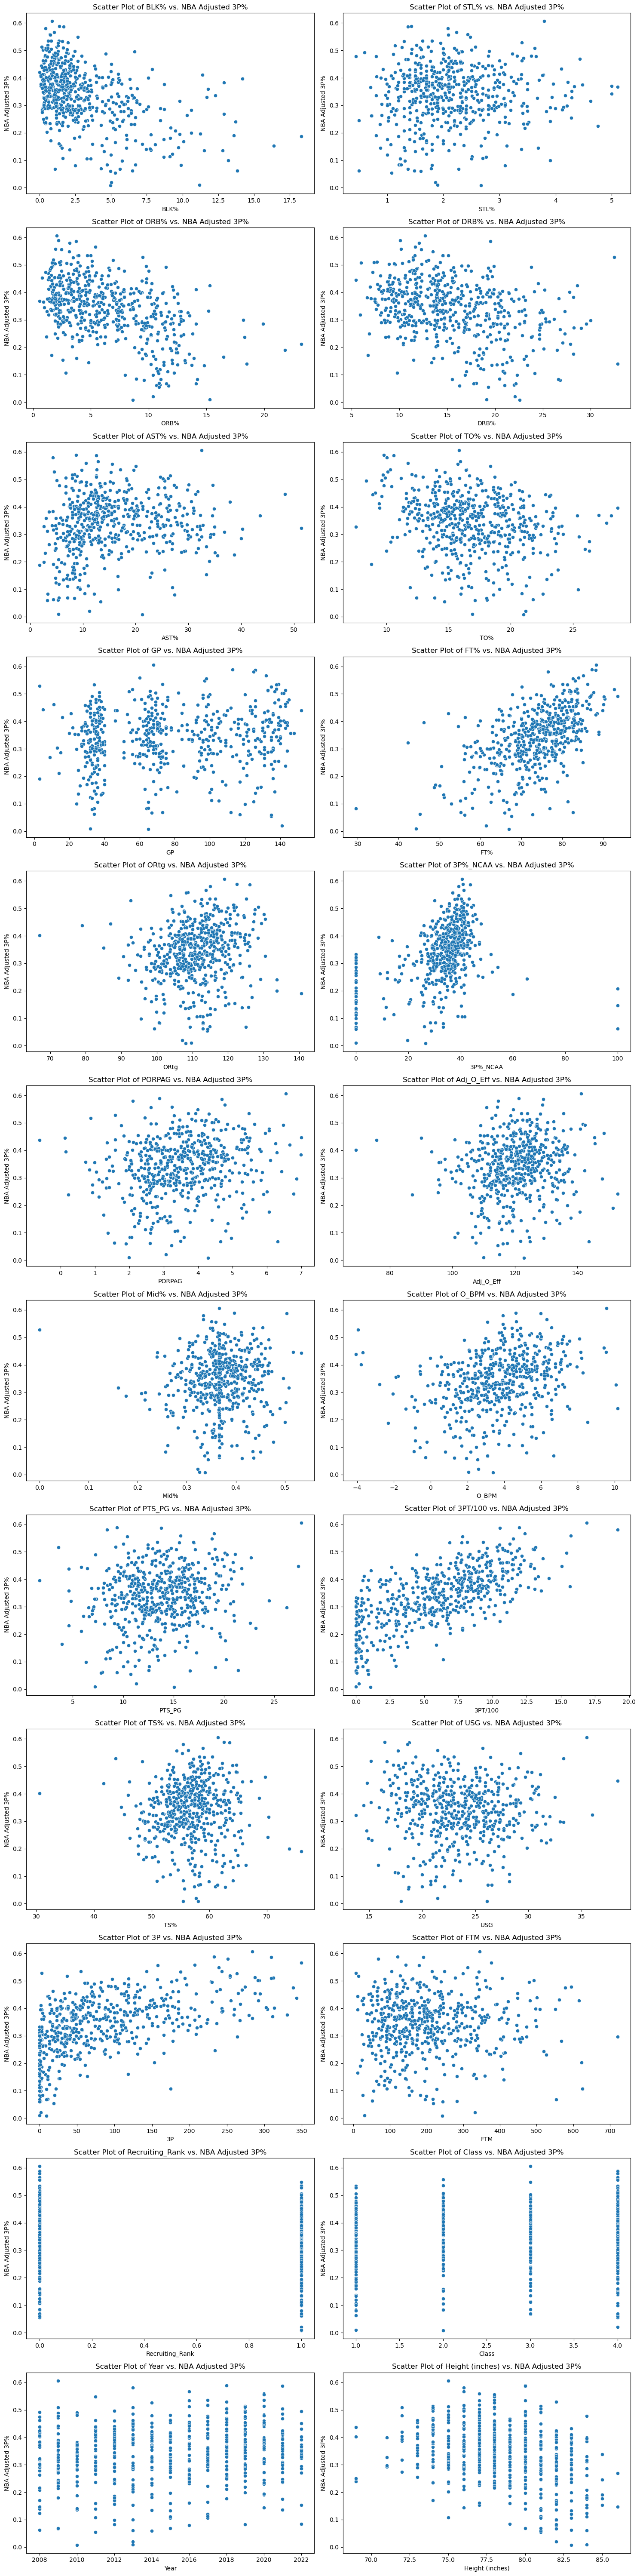

In [15]:

def create_scatter_plots(df, target_variable):
    # Filter out non-numeric columns
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    feature_names = [col for col in numeric_columns if col != target_variable]

    num_features = len(feature_names)
    num_rows = num_features // 2 + num_features % 2  # Calculate the number of rows for subplots
    num_cols = 2  # Two plots per row

    plt.figure(figsize=(15, 5 * num_rows))

    for i, feature in enumerate(feature_names):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.scatterplot(data=df, x=feature, y=target_variable)
        plt.title(f'Scatter Plot of {feature} vs. {target_variable}')
        
        # Calculate axis limits with a buffer
        x_min, x_max = df[feature].min() - 0.05 * (df[feature].max() - df[feature].min()), df[feature].max() + 0.05 * (df[feature].max() - df[feature].min())
        y_min, y_max = df[target_variable].min() - 0.05 * (df[target_variable].max() - df[target_variable].min()), df[target_variable].max() + 0.05 * (df[target_variable].max() - df[target_variable].min())
        
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        
        plt.xlabel(feature)
        plt.ylabel(target_variable)

    plt.tight_layout()
    plt.show()

# Example usage:
target_variable = 'NBA Adjusted 3P%'  # Replace with your target variable name
create_scatter_plots(df, target_variable)


In [16]:
df.drop(columns = 'Player').corr()

,BLK%,STL%,ORB%,DRB%,AST%,TO%,GP,FT%,ORtg,3P%_NCAA,...,3PT/100,TS%,USG,3P,FTM,Recruiting_Rank,Class,Year,Height (inches),NBA Adjusted 3P%
BLK%,1.000000,-0.205848,0.668683,0.614991,-0.480426,0.001836,-0.195347,-0.375913,0.075631,-0.286713,...,-0.545221,0.264781,-0.060945,-0.463985,-0.223446,0.114952,-0.181757,0.011595,0.677294,-0.465042
STL%,-0.205848,1.000000,-0.236071,-0.187102,0.498635,0.248818,0.042661,-0.009473,-0.134788,0.052545,...,0.101432,-0.208405,0.114605,0.062698,0.085644,-0.049808,0.067300,-0.079249,-0.410748,0.028408
ORB%,0.668683,-0.236071,1.000000,0.739171,-0.568619,-0.071608,-0.150843,-0.513282,0.124672,-0.411220,...,-0.685071,0.218193,0.034808,-0.536427,-0.131866,0.107091,-0.144423,-0.110613,0.702620,-0.489108
DRB%,0.614991,-0.187102,0.739171,1.000000,-0.442885,-0.054791,-0.126910,-0.335811,0.036894,-0.240594,...,-0.477376,0.201946,0.152136,-0.412080,-0.097896,0.049269,-0.126311,0.081098,0.690576,-0.351561
AST%,-0.480426,0.498635,-0.568619,-0.442885,1.000000,0.373094,0.081667,0.207413,-0.084469,0.186149,...,0.229732,-0.198816,0.318867,0.212636,0.232079,-0.051254,0.118327,-0.069481,-0.631509,0.123801
TO%,0.001836,0.248818,-0.071608,-0.054791,0.373094,1.000000,-0.072864,-0.250253,-0.558907,-0.133018,...,-0.268771,-0.237359,0.063883,-0.253735,-0.080837,0.044997,-0.054761,-0.181206,-0.096606,-0.239963
GP,-0.195347,0.042661,-0.150843,-0.126910,0.081667,-0.072864,1.000000,0.182004,0.078115,0.138619,...,0.117765,-0.004679,-0.216694,0.605640,0.713781,-0.456975,0.821793,0.034268,-0.142602,0.101901
FT%,-0.375913,-0.009473,-0.513282,-0.335811,0.207413,-0.250253,0.182004,1.000000,0.368836,0.426628,...,0.557416,0.252034,0.077971,0.498129,0.304871,-0.076613,0.179699,0.083192,-0.324147,0.560292
ORtg,0.075631,-0.134788,0.124672,0.036894,-0.084469,-0.558907,0.078115,0.368836,1.000000,0.226844,...,0.082084,0.824345,-0.136613,0.196612,0.122143,-0.020550,0.076725,0.015894,0.072523,0.154447
3P%_NCAA,-0.286713,0.052545,-0.411220,-0.240594,0.186149,-0.133018,0.138619,0.426628,0.226844,1.000000,...,0.466891,0.159171,0.017306,0.385306,0.126351,-0.123900,0.164300,0.017683,-0.256662,0.384465


In [17]:


features = df.drop(columns=['Player', 'Year', 'NBA Adjusted 3P%'])


X = features
y = df['NBA Adjusted 3P%']  # Target variable (dependent variable)


<Axes: >

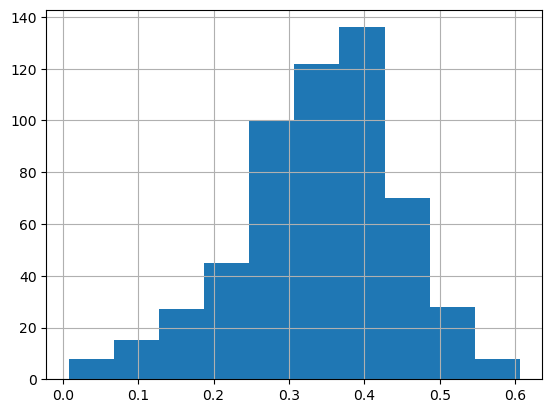

In [18]:
y.hist()

## Multiple Linear Regression

In [19]:
model = sm.OLS(y, sm.add_constant(X))

In [20]:
results = model.fit()

In [21]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       NBA Adjusted 3P%   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     31.24
Date:                Thu, 08 Feb 2024   Prob (F-statistic):           1.14e-83
Time:                        20:00:19   Log-Likelihood:                 708.50
No. Observations:                 559   AIC:                            -1369.
Df Residuals:                     535   BIC:                            -1265.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1174      0.200     

Linear R